In [2]:
# %% Import Libraries
#This is a test
import os
import pickle
import scipy.io
import numpy as np
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import ruptures as rpt
from scipy.stats import zscore

import matplotlib.patches as mpatches
from tqdm import tqdm
from bptt.models import Model
import model_anafunctions as func

plt.rcParams['font.size'] = 20

c:\Users\cestarellas\anaconda3\envs\PLAna\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Individual example of Change points in behaviour data

Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 55/55 [00:07<00:00,  7.74it/s]


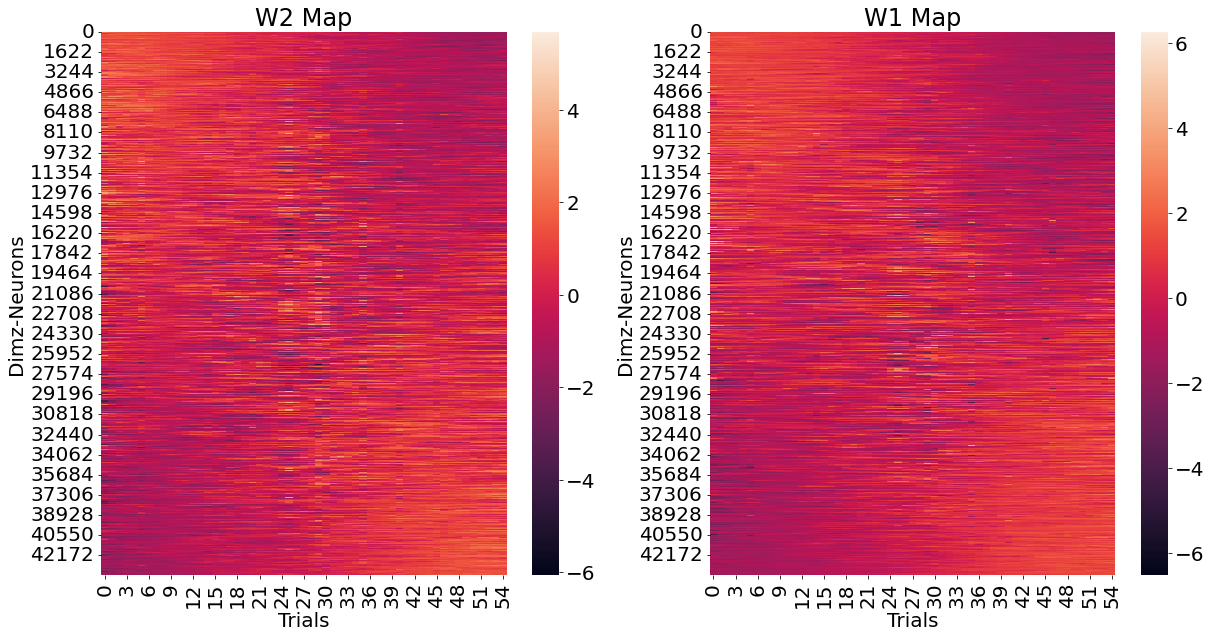

(43776, 55)

In [29]:
data_path = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets' 
# Select Path for Models (Folder containing the specific models to test)
model_path = 'D:/_work_cestarellas/Analysis/Pack_Daniel_project/Preprocess_model/bptt_CE17/results'

#%% Loading models and simulations
model_name = 'DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400/001'
mpath=os.path.join(model_path,model_name).replace('\\','/')


train_n,train_i = func.load_data(data_path,'Training')
test_n,test_i = func.load_data(data_path,'Test')
NeuronPattern={"Training_Neuron":train_n,"Training_Input":train_i,
               "Testing_Neuron":test_n,"Testing_Input":test_i}

# Loading Metadata info
file=open(os.path.join(data_path,'Metadata.pkl'),'rb')
Metadata_info=pickle.load(file)
file.close()

# Load Model
num_epochs = 150000
m = Model()
m.init_from_model_path(mpath, epoch=num_epochs)
m.eval()
# Generation Training Data
ModelS=[]
for w_index in tqdm(range(len(NeuronPattern["Training_Neuron"]))):
    data_trial=tc.from_numpy(NeuronPattern["Training_Neuron"][w_index]).float()          # tensor of neuronal data for initial trial data
    input_trial = tc.from_numpy(NeuronPattern["Training_Input"][w_index]).float()
    length_sim = input_trial.shape[0]
    X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
    ModelS.append(X[:,:])
Model_Signal,_=func.concatenate_list(ModelS,0)
Train_Signal,_=func.concatenate_list(train_n,0)

_, W1t, W2t, _, _, _ = m.get_latent_parameters()
# Transform tensor to numpy format
W2 = W2t.detach().numpy().transpose(1,2,0)
W1 = W1t.detach().numpy().transpose(1,2,0)

# Parameters
HU=W2.shape[1]                      # Number hidden units
Neurons=W2.shape[0]                 # Number Neurons
Trials=W2.shape[2]                  # Number Trials

# W2 Matrix
W2_np = W2
mat=W2_np
mat=mat.reshape(-1,mat.shape[2])
mat=zscore(mat,axis=1)
sort_pos = func.sort_by_slope(mat)
mat=mat[sort_pos,:]

# W1 Matrix
W1_np = W1
mat1=W1_np
mat1=mat1.reshape(-1,mat1.shape[2])
mat1=zscore(mat1,axis=1)
sort_pos = func.sort_by_slope(mat1)
mat1=mat1[sort_pos,:]

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# Set font size for both plots
plt.rcParams['font.size'] = 20
# Plot heatmap for mat in the first subplot (left)
sns.heatmap(data=mat, ax=axes[0])
axes[0].set_title('W2 Map')
axes[0].set_xlabel('Trials')
axes[0].set_ylabel('Dimz-Neurons')
# Plot heatmap for mat1 in the second subplot (right)
sns.heatmap(data=mat1, ax=axes[1])
axes[1].set_title('W1 Map')
axes[1].set_xlabel('Trials')
axes[1].set_ylabel('Dimz-Neurons')
plt.show()
mat.shape


In [32]:
BehData.shape

(216, 19)

In [153]:
data_path = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets' 
full_n,full_i = func.load_data(data_path,'FullSession')

In [172]:
# Concatenating signals
Nseries,_=func.concatenate_list(full_n,0)          # recorded activity
Iseries,_=func.concatenate_list(full_i,0)          # external input
# Temporal sectors: Period of time selected to compute the mean firing rate
Time_ini = np.where(np.diff(Iseries[:,0])==1)[0]-49                 # Initial point: Beginning trial
Time_end = np.append(Time_ini[1:],Iseries.shape[0])                   # Final point: Ending trial

# Data Set Mean Activity Zscore Neurons
num_trials = len(Time_end)
num_neurons = Nseries.shape[1]
X_data = np.zeros((num_trials,num_neurons))
X_model = np.zeros((num_trials,num_neurons))
for it in range(num_trials):
    X_data[it,:]=np.mean(Nseries[Time_ini[it]:Time_end[it],:],0)

Mean_full=X_data.mean(1)
Std_full = X_data.std(1)/X_data.shape[1]
print(Std_full.shape)



(185,)


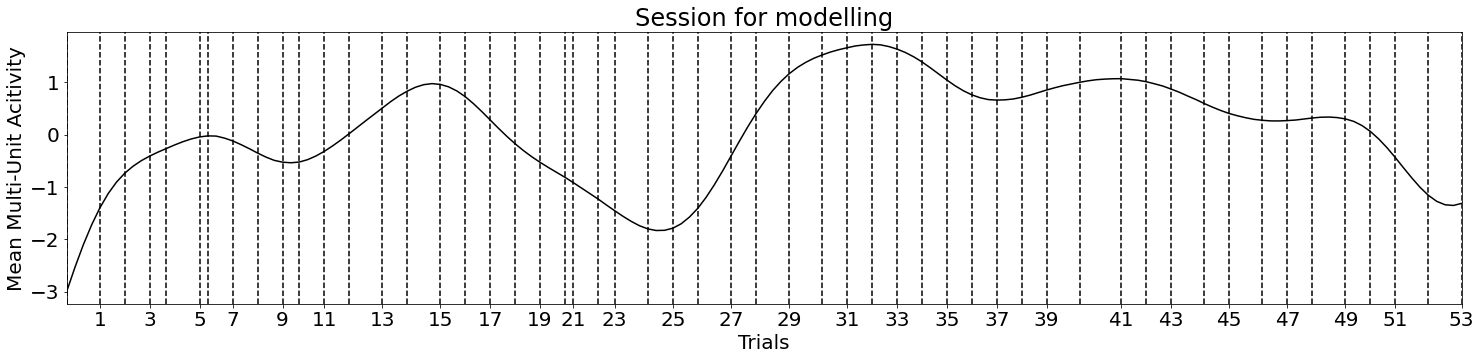

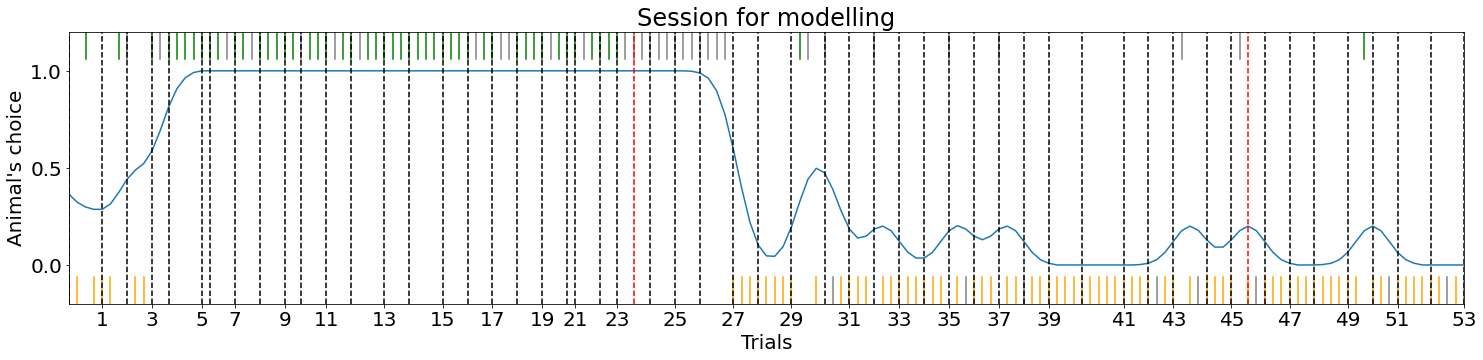

In [176]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% BEHAVIOUR %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
path_beh='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/CE17_L6'




os.chdir(path_beh)
list_files = os.listdir(path_beh)

for i in list_files:
    if i.find('Behaviour')>0:
        Behaviour_name = i

# Load data
# Open the Behaviour file
Bdata = scipy.io.loadmat(Behaviour_name)
BehData = Bdata[list(Bdata.keys())[-1]]
# Classification of trials following the behabiour
GambleRewardTrials = np.where((BehData[:,12]==1) & (BehData[:,13]==1))[0]
GambleNoRewardTrials =  np.where((BehData[:,12]==1) & (BehData[:,13]==0))[0]
SafeRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==1))[0]
SafeNoRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==0))[0]
NoRespondingTrials = np.where(BehData[:,10]==1)[0]

# Blocks
Block_Prob = np.unique(BehData[:,5])
BlockTrials = [np.where(Block_Prob[i]==BehData[:,5])[0][0] for i in range(len(Block_Prob))]
# Smoothing the data for plotting
ScaleDecision=BehData[:,12]+(BehData[:,12]-1)
SigmaDecision=1
Binx =0.5
KernelWindow = np.arange(-3*SigmaDecision, 3*SigmaDecision, Binx)
KernelDecision = np.exp(-(KernelWindow/SigmaDecision)**2/2)
DecisionConvolution=np.convolve(ScaleDecision,KernelDecision,mode='same')
DecisionNormalized=(DecisionConvolution/np.nanmax(np.abs(DecisionConvolution))+1)/2
SigmaDecision=3
Binx =0.5
KernelWindow = np.arange(-3*SigmaDecision, 3*SigmaDecision, Binx)
KernelDecision = np.exp(-(KernelWindow/SigmaDecision)**2/2)
CPlus_full=np.convolve(Std_full,KernelDecision,mode='same')
CMean_full = np.convolve(Mean_full,KernelDecision,mode='same')


if NoRespondingTrials[0]<20:
    first_trial = NoRespondingTrials[0]+1
    last_trial = NoRespondingTrials[1]-1
else:
    first_trial = 0
    last_trial = NoRespondingTrials[0]-1

if np.isnan(DecisionNormalized).any():
    # Find indices of valid values and their corresponding values
    valid_indices = np.where(~np.isnan(DecisionNormalized))[0]
    valid_values = DecisionNormalized[valid_indices]

    # Generate indices to interpolate (including NaNs)
    interpolate_indices = np.arange(len(DecisionNormalized))

    # Interpolate NaN values
    interpolated_values = np.interp(interpolate_indices, valid_indices, valid_values)
    BD = interpolated_values[0:last_trial]
else:
    BD=DecisionNormalized[0:last_trial]


# Behaviour

# Perform change point detection
algo = rpt.Window(model="l2",width=10).fit(BD)
result_beh = algo.predict(n_bkps=2)


# Concatenated Trials
SR_m=1/0.02
V_mend=[ModelS[i].shape[0]/SR_m for i in range(len(ModelS))]
T_mend=np.zeros((len(V_mend),1))
T_mstart=np.zeros((len(V_mend),1))
T_mend[0]=V_mend[0]
for i in range(1,len(V_mend)):
    T_mend[i]=V_mend[i]+T_mend[i-1]
    T_mstart[i]=T_mend[i-1]

SR_r=20000
StartTrial = np.array(BehData[:,15]/SR_r)                                                  # times of trial initiation
T_rstart=StartTrial-StartTrial[0]
Model_trial=[]
for i in range(len(T_mstart)):
    Model_trial.append(np.sum(T_rstart<T_mstart[i]))

label_xticks = [ i for i in range(len(Model_trial))]

# FIGURE: Plot behaviour performance Multivariate Unit Activity
plt.figure(figsize=(25,5))
plt.plot(zscore(CMean_full),c='k')
for i in Model_trial:
    plt.axvline(i,linestyle='dashed',color='k',)   
plt.xlim([first_trial,150])
plt.xticks(Model_trial[1:-1:2],label_xticks[1:-1:2])
plt.xlabel('Trials')
plt.ylabel("Mean Multi-Unit Acitivity")
plt.title('Session for modelling')
plt.savefig("D:/_work_cestarellas/Analysis/Pack_Daniel_project/Figures/Figure_change_point/Multi_Activity.pdf")

# FIGURE: Plot behaviour performance
plt.figure(figsize=(25,5))
plt.plot(DecisionNormalized)
plt.plot(CMean_full)
for i in GambleRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='g') 
for i in GambleNoRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='gray')
for i in SafeRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='orange')
for i in SafeNoRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='gray')
for i in NoRespondingTrials:
    plt.axvline(i,ymin=0.45,ymax=0.55,color='blue')
for i in BlockTrials:
    plt.axvline(i,linestyle='dashed',color='r',)    
for i in Model_trial:
    plt.axvline(i,linestyle='dashed',color='k',)   
plt.ylim([-0.2,1.2])
plt.yticks(ticks=[1.0,0.5,0.0])
plt.xlim([first_trial,150])
plt.xticks(Model_trial[1:-1:2],label_xticks[1:-1:2])
plt.xlabel('Trials')
plt.ylabel("Animal's choice")
plt.title('Session for modelling')
plt.savefig("D:/_work_cestarellas/Analysis/Pack_Daniel_project/Figures/Figure_change_point/Behaviour.pdf")


In [5]:
data_path = "D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets"
train_n,train_i = func.load_data(data_path,'Training')
test_n,test_i = func.load_data(data_path,'Test')

# Loading Metadata info
file=open(os.path.join(data_path,'Metadata.pkl'),'rb')
Metadata_info=pickle.load(file)
file.close()

Test_trials = Metadata_info["TestTrials"]; Training_trials = Metadata_info["TrainingTrials"]    

itrain = 0
itest = 0
Trials_inmodel = []
for i in range(len(Training_trials)+len(Test_trials)):
    if i in Training_trials:
        Trials_inmodel.append(np.sum(np.diff(train_i[itrain][:,0])==1))
        itrain += 1
    elif i in Test_trials:
        Trials_inmodel.append(np.sum(np.diff(test_i[itest][:,0])==1))
        itest +=1

# Cumulative sum of the behavioural trials in concatenated trials        
CUM_trials = [np.sum(Trials_inmodel[:i]) for i in range(len(Trials_inmodel)+1)]

Ini_beh = [0]+[CUM_trials[i+1] for i in Test_trials]
End_beh = [CUM_trials[i] for i in Test_trials]+[CUM_trials[-1]]

Tr_behaviour = []
for k in range(len(Ini_beh)):
    Tr_behaviour= Tr_behaviour+[i for i in range(Ini_beh[k],End_beh[k])]

# Relation between change points in the behaviour from experimental trials and training trials
ch_behaviour_trialmodel =[]
for i in range(len(result_beh)-1):
    model_pos = np.sum(np.array(CUM_trials)<result_beh[i])
    ch_behaviour_trialmodel.append(np.where(np.array(Training_trials)==model_pos)[0])

cp_final = []
for i in range(len(result_beh)-1):
    cp_final.append(ch_behaviour_trialmodel[i][0])


# Change point of the behaviour for all the sessions

In [4]:
#%% FUNCTIONS
def Hyper_mod(mpath,data_path):
    file=open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),'rb')
    hyper=pickle.load(file)
    file.close()
    hyper['data_path']=os.path.join(data_path,'Training_data.npy').replace('\\','/')
    hyper['inputs_path']=os.path.join(data_path,'Training_inputs.npy').replace('\\','/')
    hyper['device_id'] = 0
    full_name = open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),"wb")                      # Name for training data
    pickle.dump(hyper,full_name)            # Save train data
    #close save instance 
    full_name.close()


def CP_behaviour(path_beh,out_of_limits,data_path):
    os.chdir(path_beh)
    list_files = os.listdir(path_beh)

    for i in list_files:
        if i.find('Behaviour')>0:
            Behaviour_name = i

    # Load data
    # Open the Behaviour file
    Bdata = scipy.io.loadmat(Behaviour_name)
    BehData = Bdata[list(Bdata.keys())[-1]]
    # Classification of trials following the behabiour

    NoRespondingTrials = np.where(BehData[:,10]==1)[0]

    # Smoothing the data for plotting
    ScaleDecision=BehData[:,12]+(BehData[:,12]-1)
    SigmaDecision=1
    Binx =0.5
    KernelWindow = np.arange(-3*SigmaDecision, 3*SigmaDecision, Binx)
    KernelDecision = np.exp(-(KernelWindow/SigmaDecision)**2/2)
    DecisionConvolution=np.convolve(ScaleDecision,KernelDecision,mode='same')
    DecisionNormalized=(DecisionConvolution/np.nanmax(np.abs(DecisionConvolution))+1)/2

    if NoRespondingTrials[0]<20:
        last_trial = NoRespondingTrials[1]-1
    else:
        last_trial = NoRespondingTrials[out_of_limits]-1

    if np.isnan(DecisionNormalized).any():
        # Find indices of valid values and their corresponding values
        valid_indices = np.where(~np.isnan(DecisionNormalized))[0]
        valid_values = DecisionNormalized[valid_indices]

        # Generate indices to interpolate (including NaNs)
        interpolate_indices = np.arange(len(DecisionNormalized))

        # Interpolate NaN values
        interpolated_values = np.interp(interpolate_indices, valid_indices, valid_values)
        BD = interpolated_values[0:last_trial]
    else:
        BD=DecisionNormalized[0:last_trial]


    # Behaviour

    # Perform change point detection
    algo = rpt.Window(model="l2",width=10).fit(BD)
    result_beh = algo.predict(n_bkps=2)

    _,train_i = func.load_data(data_path,'Training')
    _,test_i = func.load_data(data_path,'Test')

    # Loading Metadata info
    file=open(os.path.join(data_path,'Metadata.pkl'),'rb')
    Metadata_info=pickle.load(file)
    file.close()

    Test_trials = Metadata_info["TestTrials"]; Training_trials = Metadata_info["TrainingTrials"]    

    itrain = 0
    itest = 0
    Trials_inmodel = []
    for i in range(len(Training_trials)+len(Test_trials)):
        if i in Training_trials:
            Trials_inmodel.append(np.sum(np.diff(train_i[itrain][:,0])==1))
            itrain += 1
        elif i in Test_trials:
            Trials_inmodel.append(np.sum(np.diff(test_i[itest][:,0])==1))
            itest +=1

    # Cumulative sum of the behavioural trials in concatenated trials        
    CUM_trials = [np.sum(Trials_inmodel[:i]) for i in range(len(Trials_inmodel)+1)]

    Ini_beh = [0]+[CUM_trials[i+1] for i in Test_trials]
    End_beh = [CUM_trials[i] for i in Test_trials]+[CUM_trials[-1]]

    Tr_behaviour = []
    for k in range(len(Ini_beh)):
        Tr_behaviour= Tr_behaviour+[i for i in range(Ini_beh[k],End_beh[k])]

    # Relation between change points in the behaviour from experimental trials and training trials
    ch_behaviour_trialmodel =[]
    for i in range(len(result_beh)-1):
        model_pos = np.sum(np.array(CUM_trials)<result_beh[i])
        ch_behaviour_trialmodel.append(np.where(np.array(Training_trials)==model_pos)[0])

    cp_final = []
    for i in range(len(result_beh)-1):
        cp_final.append(ch_behaviour_trialmodel[i][0])

    return BD

def Generation_Matrixes(data_path,mpath,num_epoch,event):
    # Loading Train and Test data    
    train_n,train_i = func.load_data(data_path,'Training')
    test_n,test_i = func.load_data(data_path,'Test')

    # Loading Model
    num_epochs = num_epoch
    m = Model()
    m.init_from_model_path(mpath, epoch=num_epochs)
    m.eval()

    # Generation Training Data
    ModelS=[]
    for w_index in tqdm(range(len(train_n))):
        data_trial=tc.from_numpy(train_n[w_index]).float()          # tensor of neuronal data for initial trial data
        input_trial = tc.from_numpy(train_i[w_index]).float()
        length_sim = input_trial.shape[0]
        X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
        ModelS.append(X[:,:])

    # Concatenating signals
    Nseries,_=func.concatenate_list(train_n,0)          # recorded activity
    Iseries,_=func.concatenate_list(train_i,0)          # external input
    Mseries,_=func.concatenate_list(ModelS,0)           # simulated activity
    
    if event == 1:
        # Temporal sectors: Period of time selected to compute the mean firing rate
        Time_ini = np.where(np.diff(Iseries[:,0])==1)[0]-49                        # Initial point:beginning wheel stop
        Time_end = np.where(np.diff(Iseries[:,0])==-1)[0]                          # Final point: ending execution time. Just before reward
    elif event == 2:
        # Temporal sectors: Period of time selected to compute the mean firing rate
        Time_ini = np.where(np.diff(Iseries[:,0])==-1)[0]                       # Initial point: beginning reward
        RT_end = np.where(np.diff(Iseries[:,0])==1)[0]-49
        Time_end = np.append(RT_end[1:],Iseries.shape[0])                       # Final point: ending Inter-Trial Interval (beggining following trial)
    elif event == 3:
        # Temporal sectors: Period of time selected to compute the mean firing rate
        Time_ini = np.where(np.diff(Iseries[:,0])==1)[0]-49                 # Initial point: Beginning trial
        Time_end = np.append(Time_ini[1:],Iseries.shape[0])                   # Final point: Ending trial

    
    # Data Set Mean Activity Zscore Neurons
    num_trials = len(Time_end)
    num_neurons = Nseries.shape[1]
    X_data = np.zeros((num_trials,num_neurons))
    X_model = np.zeros((num_trials,num_neurons))
    for it in range(num_trials):
        X_data[it,:]=np.mean(Nseries[Time_ini[it]:Time_end[it],:],0)
        X_model[it,:]=np.mean(Mseries[Time_ini[it]:Time_end[it],:],0)
    
    return X_data,X_model

def Generation_W(mpath):      
    # Load Model
    num_epochs = 150000
    m = Model()
    m.init_from_model_path(mpath, epoch=num_epochs)
    m.eval()

    _, W1t, W2t, _, _, _ = m.get_latent_parameters()
    # Transform tensor to numpy format
    W2 = W2t.detach().numpy().transpose(1,2,0)
    W1 = W1t.detach().numpy().transpose(1,2,0)

    # Parameters
    HU=W2.shape[1]                      # Number hidden units
    Neurons=W2.shape[0]                 # Number Neurons
    Trials=W2.shape[2]                  # Number Trials

    # W2 Matrix
    W2_np = W2
    mat=W2_np
    mat=mat.reshape(-1,mat.shape[2])
    mat=zscore(mat,axis=1)
    sort_pos = func.sort_by_slope(mat)
    mat=mat[sort_pos,:]

    # W1 Matrix
    W1_np = W1
    mat1=W1_np
    mat1=mat1.reshape(-1,mat1.shape[2])
    mat1=zscore(mat1,axis=1)
    sort_pos = func.sort_by_slope(mat1)
    mat1=mat1[sort_pos,:]

    return mat,mat1

In [5]:
#%% Data Organization
# General Directories
path_models = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\' # For models and Training and Test data
path_behaviours = 'D:\\_work_cestarellas\\Analysis\\PLRNN\\Session_Selected\\OFC'        # For behavioural sessions

#Model
mod_sessions = os.listdir(path_models)
extra_models = 'results\\DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400\\001'
#Neuronal Activity
extra_activity = 'neuralactivity\\datasets\\'
#Behaviour
rec_sessions = os.listdir(path_behaviours)

#################### WARNING
# Be careful!!! Check if the order of mod_sessions and rec_sessions is the same
#################### WARNING
print(mod_sessions)
print(rec_sessions)

['bptt_CE17', 'bptt_DM01_5', 'bptt_DM01_7', 'bptt_JG15_24', 'bptt_JG15_25']
['CE17_L6', 'DM01_5_220522', 'DM01_7_220524', 'JG15_190724_clustered', 'JG15_190725_clustered']


In [8]:
num_sessions = len(mod_sessions)
last_epoch = 150000
Choice_rec = [] ; Choice_gen =[]
Reward_rec = [] ; Reward_gen =[]
Block_rec = [] ; Block_gen =[]
limit_fail = [0,3,3,0,0]
cp_beh = []
for isess in range(num_sessions):
    Neural_path = os.path.join(path_models,mod_sessions[isess],extra_activity)
    Model_path = os.path.join(path_models,mod_sessions[isess],extra_models).replace('\\','/')
    Behavioural_path = os.path.join(path_behaviours,rec_sessions[isess]).replace('\\','/')
    Hyper_mod(Model_path,Neural_path)
    # Behaviour decision temporal serie
    Behaviour_decision = CP_behaviour(Behavioural_path,limit_fail[isess],Neural_path)
    scipy.io.savemat('Beh_'+mod_sessions[isess]+'.mat',{'Beh':Behaviour_decision})
    # Total trial mean value
    event_flag=3
    Data_tot,Simul_tot = Generation_Matrixes(Neural_path,Model_path,last_epoch,event_flag)
    scipy.io.savemat('Tot_'+mod_sessions[isess]+'.mat',{'Rec':Data_tot,'Gen':Simul_tot})
    # W parameter changes
    W1,W2 = Generation_W(Model_path)
    scipy.io.savemat('Wparams_'+mod_sessions[isess]+'.mat',{'W1':W1,'W2':W2})


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 55/55 [00:05<00:00,  9.32it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!
Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 58/58 [00:05<00:00,  9.86it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!
Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 88/88 [00:09<00:00,  9.21it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!
Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 48/48 [00:05<00:00,  8.62it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!
Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 35/35 [00:03<00:00,  9.19it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


# Generating Wdata model

In [9]:
pwd

'D:\\_work_cestarellas\\Analysis\\PLRNN\\Session_Selected\\OFC\\JG15_190725_clustered'

In [46]:
CP_beh = [79,11,60,24,173,131,137,80,141,111]
CP_rec = [74,46,94,49,81,153,93,167,34,108]
CP_gen = [75,52,93,48,114,153,67,132,31,88]

In [38]:
data_path = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets' 
# Select Path for Models (Folder containing the specific models to test)
model_path = 'D:/_work_cestarellas/Analysis/Pack_Daniel_project/Preprocess_model/bptt_CE17/results'

#%% Loading models and simulations
model_name = 'DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400/001'
mpath=os.path.join(model_path,model_name).replace('\\','/')

result_beh = [10,78]
train_n,train_i = func.load_data(data_path,'Training')
test_n,test_i = func.load_data(data_path,'Test')
NeuronPattern={"Training_Neuron":train_n,"Training_Input":train_i,
               "Testing_Neuron":test_n,"Testing_Input":test_i}

# Loading Metadata info
file=open(os.path.join(data_path,'Metadata.pkl'),'rb')
Metadata_info=pickle.load(file)
file.close()

Test_trials = Metadata_info["TestTrials"]; Training_trials = Metadata_info["TrainingTrials"]    

itrain = 0
itest = 0
Trials_inmodel = []
for i in range(len(Training_trials)+len(Test_trials)):
    if i in Training_trials:
        Trials_inmodel.append(np.sum(np.diff(train_i[itrain][:,0])==1))
        itrain += 1
    elif i in Test_trials:
        Trials_inmodel.append(np.sum(np.diff(test_i[itest][:,0])==1))
        itest +=1

# Cumulative sum of the behavioural trials in concatenated trials        
CUM_trials = [np.sum(Trials_inmodel[:i]) for i in range(len(Trials_inmodel)+1)]

Ini_beh = [0]+[CUM_trials[i+1] for i in Test_trials]
End_beh = [CUM_trials[i] for i in Test_trials]+[CUM_trials[-1]]

Tr_behaviour = []
for k in range(len(Ini_beh)):
    Tr_behaviour= Tr_behaviour+[i for i in range(Ini_beh[k],End_beh[k])]

# Relation between change points in the behaviour from experimental trials and training trials
ch_behaviour_trialmodel =[]
for i in range(len(result_beh)):
    model_pos = np.sum(np.array(CUM_trials)<result_beh[i])
    ch_behaviour_trialmodel.append(np.where(np.array(Training_trials)==model_pos)[0])

cp_final = []
for i in range(len(result_beh)):
    cp_final.append(ch_behaviour_trialmodel[i][0])




In [145]:
def Equivalence_changepoint(BCP,NCP,MCP,Data_path):

    _,train_i = func.load_data(Data_path,'Training')
    _,test_i = func.load_data(Data_path,'Test')

    # Loading Metadata info
    file=open(os.path.join(Data_path,'Metadata.pkl'),'rb')
    Metadata_info=pickle.load(file)
    file.close()

    Test_trials = Metadata_info["TestTrials"]; Training_trials = Metadata_info["TrainingTrials"]    

    itrain = 0
    itest = 0
    Trials_inmodel = []
    for i in range(len(Training_trials)+len(Test_trials)):
        if i in Training_trials:
            Trials_inmodel.append(np.sum(np.diff(train_i[itrain][:,0])==1))
            itrain += 1
        elif i in Test_trials:
            Trials_inmodel.append(np.sum(np.diff(test_i[itest][:,0])==1))
            itest +=1

    # Cumulative sum of the behavioural trials in concatenated trials        
    CUM_trials = [np.sum(Trials_inmodel[:i]) for i in range(len(Trials_inmodel)+1)]

    Ini_beh = [0]+[CUM_trials[i+1] for i in Test_trials]
    End_beh = [CUM_trials[i] for i in Test_trials]+[CUM_trials[-1]]

    Tr_behaviour = []
    for k in range(len(Ini_beh)):
        Tr_behaviour= Tr_behaviour+[i for i in range(Ini_beh[k],End_beh[k])]

    # Relation between change points in the behaviour from experimental trials and training trials
    ch_behaviour_trialmodel =[]
    ch_recorded_trialmodel = []
    ch_generated_trialmodel = []
    for i in range(len(BCP)):
        model_pos0 = np.sum(np.array(CUM_trials)<=BCP[i])
        model_pos1 = np.sum(np.array(CUM_trials)<=NCP[i])
        model_pos2 = np.sum(np.array(CUM_trials)<=MCP[i])
        ch_behaviour_trialmodel.append(np.where(np.array(Training_trials)==model_pos0)[0])
        ch_recorded_trialmodel.append(Training_trials[model_pos1-1])
        ch_generated_trialmodel.append(Training_trials[model_pos2-1])
    cp_finalb = []
    cp_finalr = []
    cp_finalg = []
    for i in range(len(BCP)):
        cp_finalb.append(ch_behaviour_trialmodel[i][0])
        cp_finalr.append(ch_recorded_trialmodel[i]+np.sum(np.array(Test_trials)<ch_recorded_trialmodel[i]))
        cp_finalg.append(ch_generated_trialmodel[i]+np.sum(np.array(Test_trials)<ch_generated_trialmodel[i]))

    return cp_finalb,cp_finalr,cp_finalg


In [146]:
#%% Data Organization
# General Directories
path_models = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\' # For models and Training and Test data
path_behaviours = 'D:\\_work_cestarellas\\Analysis\\PLRNN\\Session_Selected\\OFC'        # For behavioural sessions

#Model
mod_sessions = os.listdir(path_models)
extra_models = 'results\\DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400\\001'
#Neuronal Activity
extra_activity = 'neuralactivity\\datasets\\'
#Behaviour
rec_sessions = os.listdir(path_behaviours)

#################### WARNING
# Be careful!!! Check if the order of mod_sessions and rec_sessions is the same
#################### WARNING
print(mod_sessions)
print(rec_sessions)

['bptt_CE17', 'bptt_DM01_5', 'bptt_DM01_7', 'bptt_JG15_24', 'bptt_JG15_25']
['CE17_L6', 'DM01_5_220522', 'DM01_7_220524', 'JG15_190724_clustered', 'JG15_190725_clustered']


In [147]:
num_sessions = len(mod_sessions)
last_epoch = 150000
Choice_rec = [] ; Choice_gen =[]
Reward_rec = [] ; Reward_gen =[]
Block_rec = [] ; Block_gen =[]
limit_fail = [0,3,3,0,0]
cp0=[];cp1=[];cp2=[]
for isess in range(num_sessions):
    Neural_path = os.path.join(path_models,mod_sessions[isess],extra_activity)
    Model_path = os.path.join(path_models,mod_sessions[isess],extra_models).replace('\\','/')
    Behavioural_path = os.path.join(path_behaviours,rec_sessions[isess]).replace('\\','/')
    B_cp = CP_beh[(isess*2):(isess*2+2)]
    N_cp = CP_rec[(isess*2):(isess*2+2)] 
    M_cp = CP_gen[(isess*2):(isess*2+2)]
    CP_b,CP_n,CP_m = Equivalence_changepoint(B_cp,N_cp,M_cp,Neural_path)
    cp0.append(CP_b)
    cp1.append(CP_n)
    cp2.append(CP_m)


In [177]:
cp0

[[26, 4], [23, 10], [60, 46], [27, 17], [28, 23]]

In [149]:
cp1

[[29, 19], [41, 20], [37, 66], [21, 39], [10, 31]]

In [150]:
cp2

[[30, 21], [41, 20], [50, 66], [16, 31], [10, 28]]

In [178]:
list_beh=[]
list_rec=[]
list_gen=[]

for i in range(len(cp0)):
    list_beh=list_beh+cp0[i]
    list_rec=list_rec+cp1[i]
    list_gen=list_gen+cp2[i]

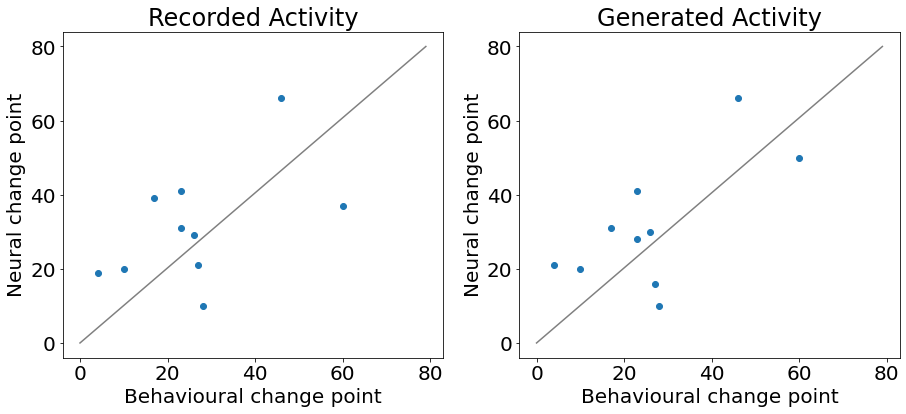

In [189]:

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot recorded activity in the first subplot
axes[0].scatter(list_beh, list_rec)
axes[0].plot(np.linspace(0, 80, 80), color='grey')  # Background line plot
axes[0].set_xlabel("Behavioural change point")
axes[0].set_ylabel("Neural change point")
axes[0].set_title("Recorded Activity")

# Plot generated activity in the second subplot
axes[1].scatter(list_beh, list_gen)
axes[1].plot(np.linspace(0, 80, 80), color='grey')  # Background line plot
axes[1].set_xlabel("Behavioural change point")
axes[1].set_ylabel("Neural change point")
axes[1].set_title("Generated Activity")
plt.savefig("D:/_work_cestarellas/Analysis/Pack_Daniel_project/Figures/Figure_change_point/Change_point_behaviour.pdf")
plt.show()
